# Applied Time Series Analysis - Lab 1
### Reading and processing data for Lab 1
Kelton Berry, Data Science, William & Mary

last edited: 2021-03-05

licence: CC-BY-NC

***




## Introduction 
For this first lab assignment, we will be applying time series techniques to explore the El Niño Southern Oscillation (ENSO). The lab is based extensively on a paper titled *Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle*, written by Lam et al in 2019. In this lab, I will begin by summarizing the above-mentioned discussion paper. I will investigate the three main datasets, the Oceanic Niño Index, El Niño Index as well as the Persons Affected by Disasters dataset, from the paper through the perspective of time-series analysis. Additionally, I include the dataset on the Arctic Oscillation, which has an oscillation akin to that of El Niño and perform a similar analysis. Specifically, with these datasets, I will replicate the time-series of "Figure 1" found on the discussion paper as well as produce sample autocorrelation and periodogram plots. My ultimate goal is to identify El Niño years in the datasets from my analysis.

#### Summarizing the Lam et al. Discussion Paper
The researchers, who were health and climate scientists (mostly from the UK), set out to explore the consequences of an El Niño phase. For context, an El Niño is the irregular occurrence of the warm phase of the ocean cycle in the Pacific Basin, affecting sea temperatures and a major influence on temperature and weather changes. The goal of the researchers was to explore the relationship between an El Niño year and people affected by natural disasters.
 
For data on El Niño's, the researchers used two separate El Niño Southern Oscillation (ENSO) indices, including the Oceanic Niño Index (ONI) and the multivariate El Niño Index (MEI). ONI captures anomalies in sea temperatures, while MEI records six variables of the Pacific, including sea-level pressure and temperature. Lastly, Persons Affected by Disaster (PAD), an emergency events database, was used to capture info on people affected by natural disasters.
 
The researchers applied time-series regression techniques, specifically Poisson Generalized Additive Models and distributed-lag non-linear models, to model the relationship between the two ENSO indices and the disaster numbers. By using these time series techniques, done in the *R* language, the researchers were able to capture the annual relationship between El Niño and disaster burdens. Through their analysis, the team found during El Niño years, people affected by disasters were significantly higher as opposed to non-El Niño years. The types of disasters often affiliated with El Niño years were storms, droughts, and most significant flood events. Additionally, the majority, about 75%, of the people affected by El Niño were located in Asia.
 
 





## Methods:
#### Importing the data
Below, I will import and clean all the necessary data. This includes the Oceanic Niño Index (ONI), the Multi-variate ENSO Index (MEI), and the Persons Affected by Disasters (PAD) from EM-DAT. I will also calculate PAD per 1000 on an annual basis. Lastly, I will import and preprocess the Arctic Oscillation (AO) dataset.  

##### Working with Oceanic Ni&ntilde;o Index (ONI)
The Oceanic Ni&ntilde;o Index (ONI) data can be found via the links below:

  - https://psl.noaa.gov/data/correlation/oni.data

    
   - https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt 

Importing the ONI dataset

In [100]:
# Define the URL, scrub the file name from the URL and download to /tmp
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')

In [101]:
# Read directly to dataframe preserving the header
oni.df <- read.table(oni.file, header = TRUE)

Subsetting the data to fit the months we are interested in exploring

In [102]:
dec_feb <- subset(oni.df, SEAS =='DJF' & YR > 1963 & YR <2018, select=c(SEAS,YR,ANOM))

Turning the ONI Anomalies data into Time-Series

In [103]:
oni.ts <- ts(oni.df$ANOM, start = c(1964, 1), end = c(2017,1), frequency = 12)

##### Working with Multi-variate ENSO Index (MEI)
The data for MEI can be imported from the HTML link below:

- "https://psl.noaa.gov/enso/mei.old/table.html"

Importing the MEI dataset

In [66]:
# Define the URL, scrub the file name, and download it to /tmp
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')

In [67]:
# Read the column names from the data
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

In [68]:
# Create an empty dataframe
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 

In [69]:
# Get all the data lines
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^[0-9].*", my.line)
  if (length(a) > 0) {
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols) {
      my.values <- c()
      for (d in my.data) {
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = my.values
    }
  }
}

Subsetting the data for the months we are attempting to explore

In [72]:
mei_dec_jan <- subset(mei.df, YEAR > 1963 & YEAR < 2018, select =c(YEAR,DECJAN))

Turning the MEI data into Time-Series

In [89]:
mei.ts <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1950, 1), frequency = 12)

#### Working Persons Affected by Disasters (PAD)
This data is downloaded from [EM DAT](https://public.emdat.be/) and the Excel file encompasses all regions limited to dates between 1964 and 2017 for all disaster types.

We must also import the population data from the UN (World Bank) to achieve PAD per 1000 people.




Importing the PAD dataset

In [106]:
#the file path of the .csv we are using 
pad.file <- "/content/emdat_public_2021_03_01_query_uid-oAL2jm.csv"
pad.df.all <- read.csv(pad.file, header=TRUE, skip=6)

In [107]:
#pulling the columns we are interested in exploring
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Affected")
pad.df <- pad.df.all[cols.interest]

Importing the Population dataset

The data on country population statistics is provided by the World Bank. The link to the population from the World Bank API is below: 
 - "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"



In [108]:
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)

In [109]:
#here we will unzip the file using the unzip function in R
unzip(zipfile = wbank.file, exdir = "/tmp")

In [110]:
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}

In [111]:
# Add the path back to the file name
wb.file <- paste("/tmp/", my.file, sep="")

In [112]:
#reading the .csv 
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)

Joining the PAD and population datasets together

In [113]:
# Loop through each row of our data frame and
# find the matching country and year
# remember that year columns in World Bank start with "X"
# and save the population to the original pad dataframe.
for (i in 1:nrow(pad.df)) {
  # Remember i is the row index in pad.df
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start.Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  # Match returns "NA" if no match
  a <- match(tmp.iso, wb.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- wb.df[,tmp.col][a]
    # We can create new dataframe columns on the fly
    pad.df[i, 'POP'] = tmp.pop
    #print(c(tmp.iso, tmp.year, tmp.pop))
  } else {
    # Make sure to assign missing values, too!
    pad.df[i, 'POP'] = NA
    #print(paste("Could not match", tmp.iso))
  }
}

Working to find PAD per 1000 people

In [15]:
#setting the years we want and an empty list to find annual PAD (per 1000) numbers
our_years <- c(1964:2017)
pad <- c()

In [115]:
#

#Here we will calculate the annual pad value
#plus we will also remove Na values
for (year in all_years){
  
  my_pad <- subset(pad.df, Start.Year == year)
  pad_year <- 0
  for (i in 1:nrow(my_pad)){
    if (!is.na(my_pad$Total.Affected[i]) & !is.na(my_pad$POP[i])) {
      my.ta <- my_pad$Total.Affected[i]
      my.tp <- my_pad$POP[i]
      pad_year <- pad_year + my.ta
    }
  }

  #Here we will find the population for countries 
  #and match country acronyms to populations
  pop <- 0
  for (iso in unique(my_pad$ISO)){
    #print(my.iso)
    a <- match(iso, my_pad$ISO)
    tmp.pop <- my_pad$POP[a]
    if (!is.na(tmp.pop)) {
      pop <- pop + tmp.pop
    }
  }

  # Calculate (per 1000) PAD for year
  pad_for_year <- pad_year/pop*1000
  pad <- append(pad, pad_for_year)
}

new_pad <- data.frame (year  = all_years, pad)


Turning the PAD data into Time-Series

In [62]:
new_pad.ts <- ts(new_pad$pad, start = c(1950, 1), frequency = 12)

#### Working with Arctic Oscillation (AO)

This dataset is from the [National Weather Service](https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao_index.html). The AO index captures the weathern pattern from the Arctic poles north of 20 degrees latitude and is a major influencer of the weather variability in Northern Hemisphere (Dahlman, L.).


It can be downloaded from the link below:
 - https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii

Importing the AO Index Dataset

In [47]:
# Define the URL, scrub the file name from the URL and download to /tmp
aoi.url <- "https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii"
aoi.name <- tail(unlist(strsplit(aoi.url, "/")), n=1)
aoi.file <- paste("/tmp/", aoi.name, sep="")
download.file(aoi.url, aoi.file, method = 'auto')

In [48]:
#we read in the data and place the year,month and AO index into a dataframe
aoi.df <- read.table(aoi.file, header = FALSE, col.names=c("Year", "Month","AO.Index"))

In [49]:
#aggregating the AO Index on an annual basis
new_aoi <- aggregate(cbind(AO.Index)~Year, FUN=sum, data = aoi.df)

We turn the AO Index into a time series object for plotting

In [56]:
#Turn AO index into a time series object
aoi.ts <- ts(aoi.df$AO.Index, start = c(1950, 1),frequency = 12)

## Results
In the results below I will create four plots for the three datasets (ONI, MEI & PAD) from the Lam et al. (2019) research paper and the additional dataset of the Arctic Oscillation (AO). The first plot is a replication of Figure 1. of the Lam et al. (2019) research paper. The second is a time-series plot, which we can do as we turned all the datasets into time-series objects. I will produce plots of a periodogram and a sample autocorrelation for each dataset. The periodogram graphs the estimate of the spectral density of a signal. We can use it to identify the dominant frequencies and periods of our time series.  The sample autocorrelation captures the measurement of the correlation between lagged values of a time series. I graph the latter two plots by installing and importing the twsge library from $R$. Then, the use of the “plotts sample” function via the twsge library, which replicates the time series, periodogram, and autocorrelation plus smoothed version of the periodogram. To conclude, I will attempt to identify El Niño years based upon the results.

In [116]:
install.packages("tswge")
library("tswge")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Results of Oceanic Nino Index (ONI)


#### ONI Figure 1. 
Captures the annual Oceanic Ni&ntilde;o Index (ONI) index value behavior from 1964 to 2017. 

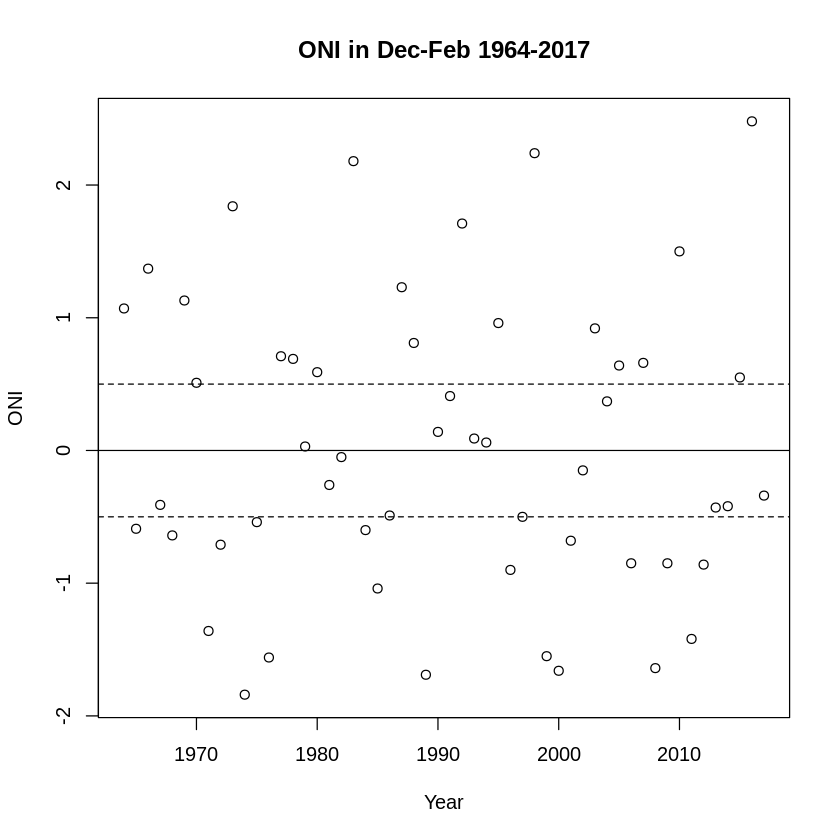

In [45]:
#plotting the time-series 

fig_1_ONI <- plot(dec_feb$YR, dec_feb$ANOM, main = "ONI in Dec-Feb 1964-2017",
 xlab = "Year",
 ylab='ONI',
 xlim=c(1964,2017))
 abline(h=0)
 abline(h=.5, lty='dashed')
 abline(h=-.5, lty="dashed")

#### ONI Time Series
Captures the three-month running average of the ONI index on an annual basis from 1964-2017. 

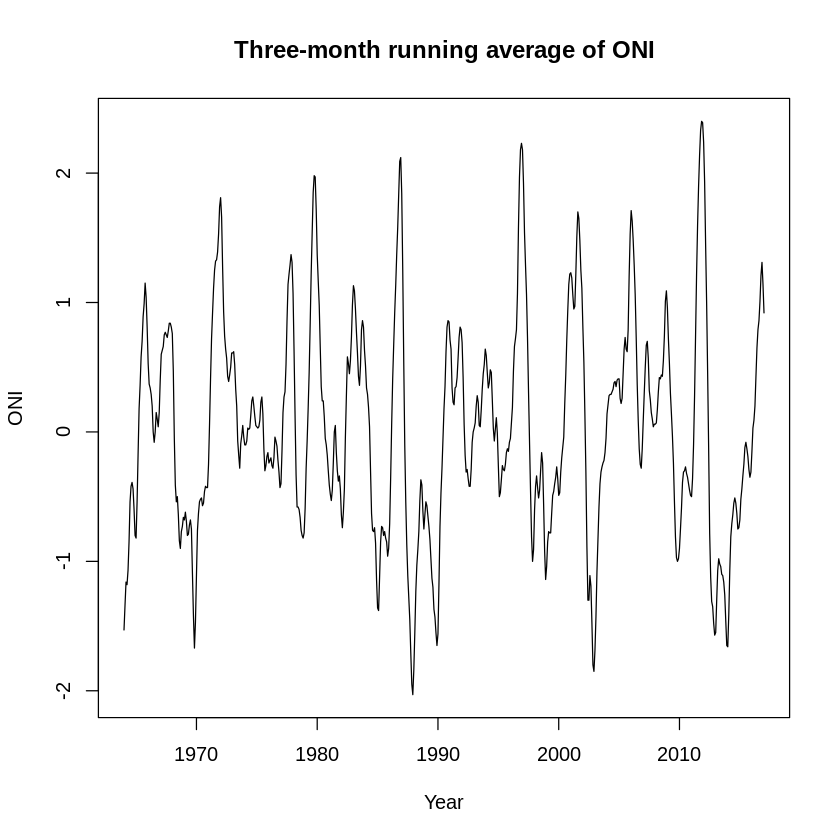

In [105]:
plot(oni.ts, xlab = "Year", ylab = "ONI", main = "Three-month running average of ONI")

#### ONI Periodogram & Autocorrelation

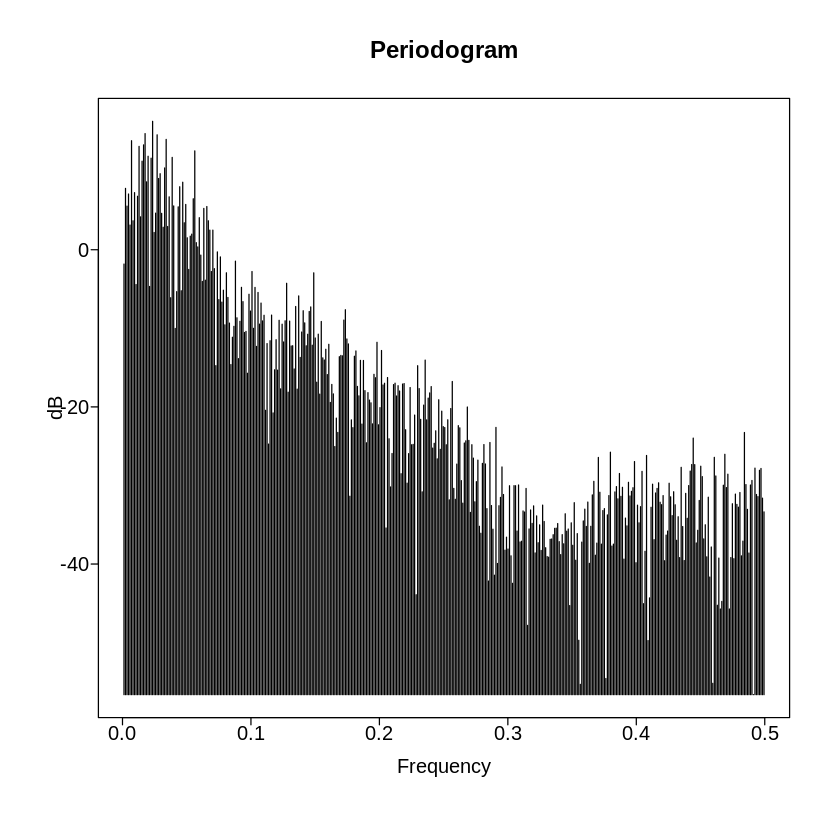

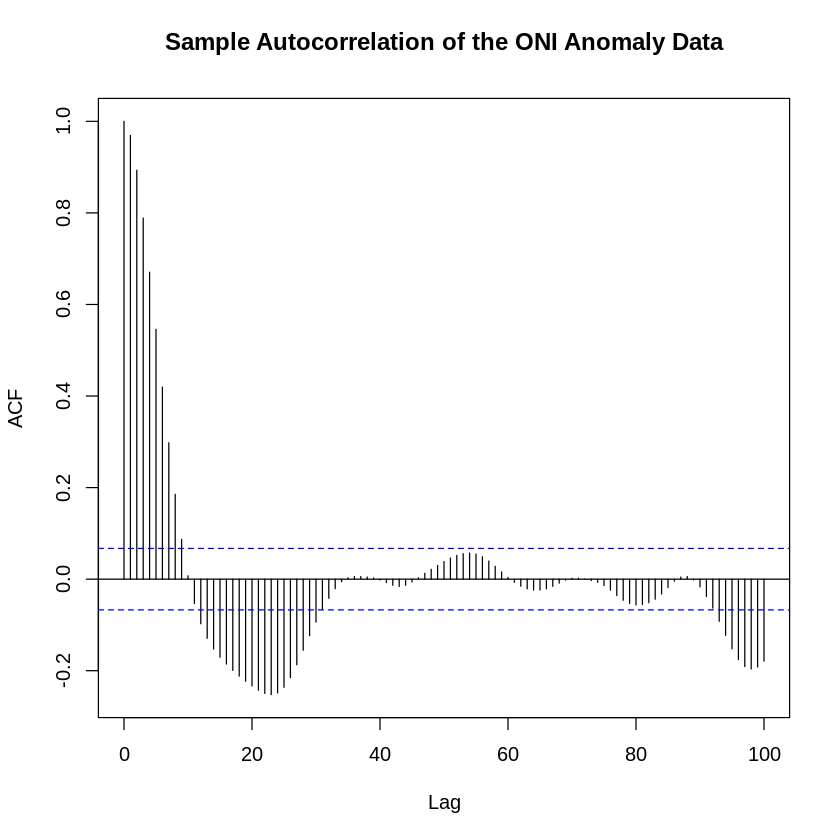

In [75]:
periodogram <- period.wge(oni.df$ANOM, plot=TRUE)
acf(oni.df$ANOM, type = "correlation", main="Sample Autocorrelation of the ONI Anomaly Data", lag = 100)

#### ONI Plotts Sample

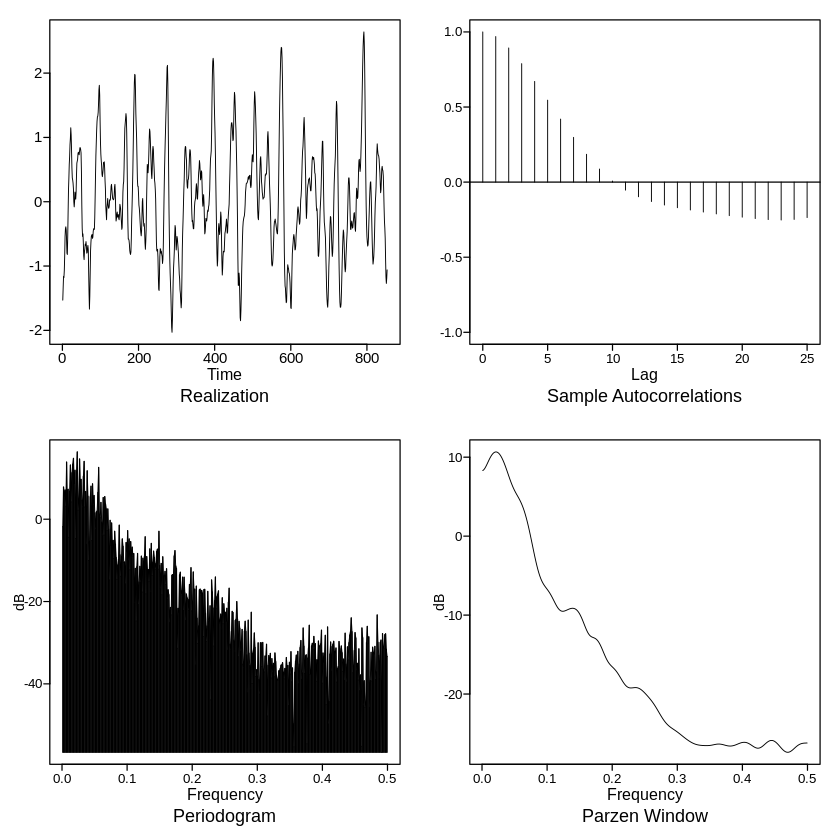

In [86]:
oni_data <- plotts.sample.wge(oni.df$ANOM)

#### Interpretation
The ONI time-series shows a clear oscillation, however, one clear pattern is not discernable. Peaks on average seem to occur 2 to 3 times a decade. The sample autocorrelation shows a slight oscillating pattern, but with no clear period. The smoothed periodogram found in the Parzen window shows a peak at about $f = .03$ which translates to a periodic behavior of period $1/.03=33.33$. In the context of this analysis, this would translate to a pattern of roughly 33 months or just about 3 years. This seems to fit the sinusoidal trend found in the sample autocorrelation with its period around (perhaps slightly greater than) 33.

### Results of Multi-variate ENSO (MEI)

#### MEI Figure 1. 
Captures the annual Multi-variate ENSO Index (MEI) index value behavior from 1964 to 2017.

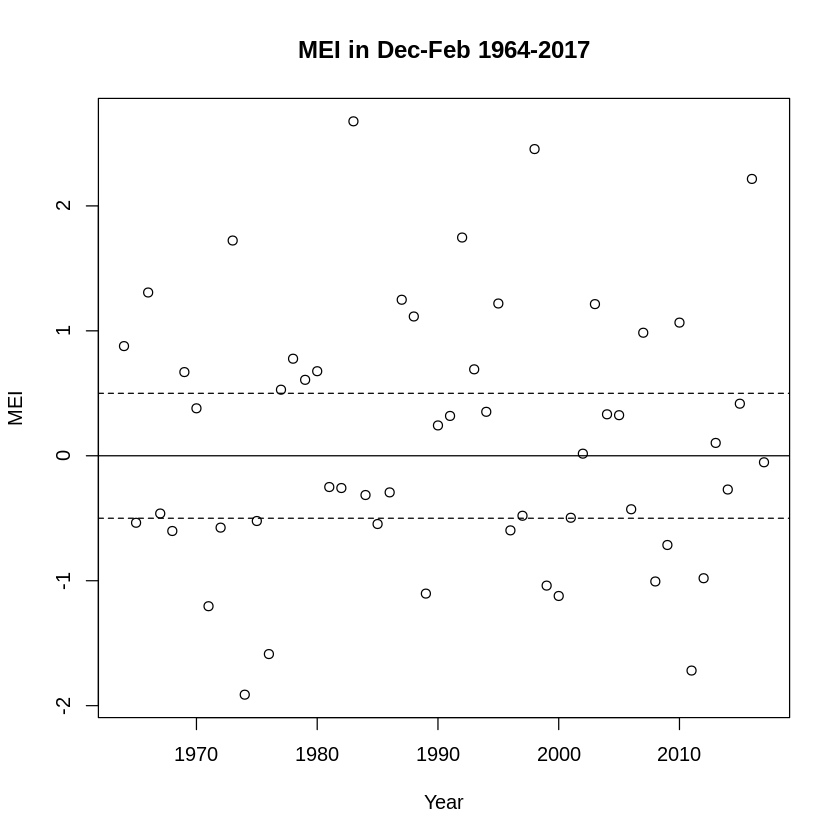

In [182]:
#Creating our time-series plot 
plot(mei_dec_jan$YEAR, mei_dec_jan$DECJAN, main = "MEI in Dec-Feb 1964-2017",
 xlab = "Year",
 ylab='MEI',
 xlim=c(1964,2017))
 abline(h=0)
 abline(h=.5, lty='dashed')
 abline(h=-.5, lty="dashed")

#### MEI Time-Series
Captures the two-month running average of the MEI index on an annual basis from 1964-2017. 

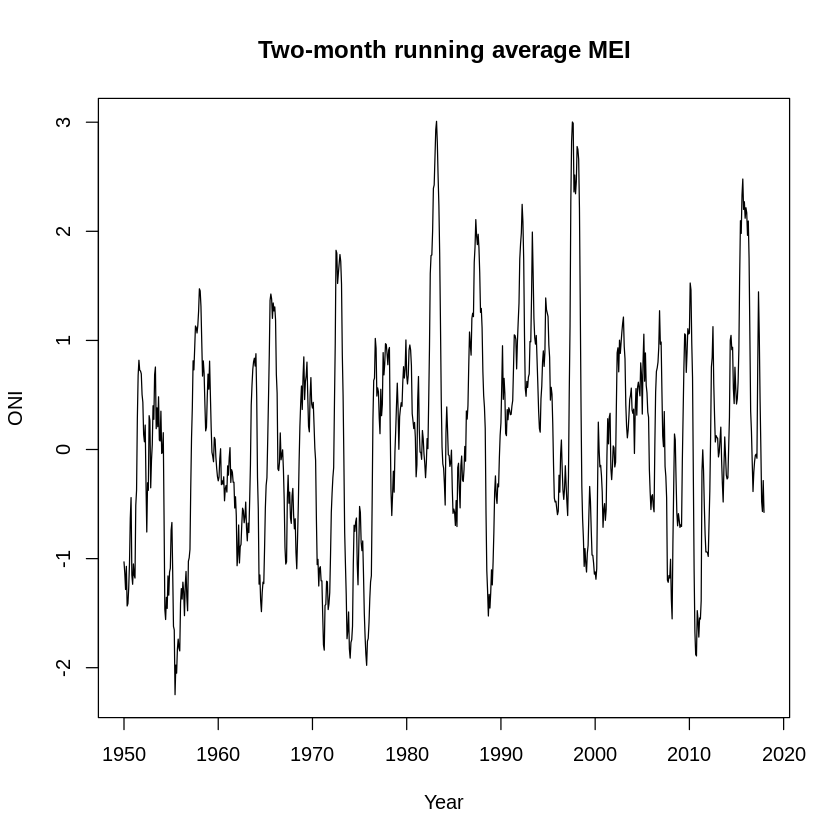

In [90]:
plot(mei.ts, xlab = "Year", ylab = "ONI", main = "Two-month running average MEI")

#### MEI Periodogram & Sample Autocorrelation

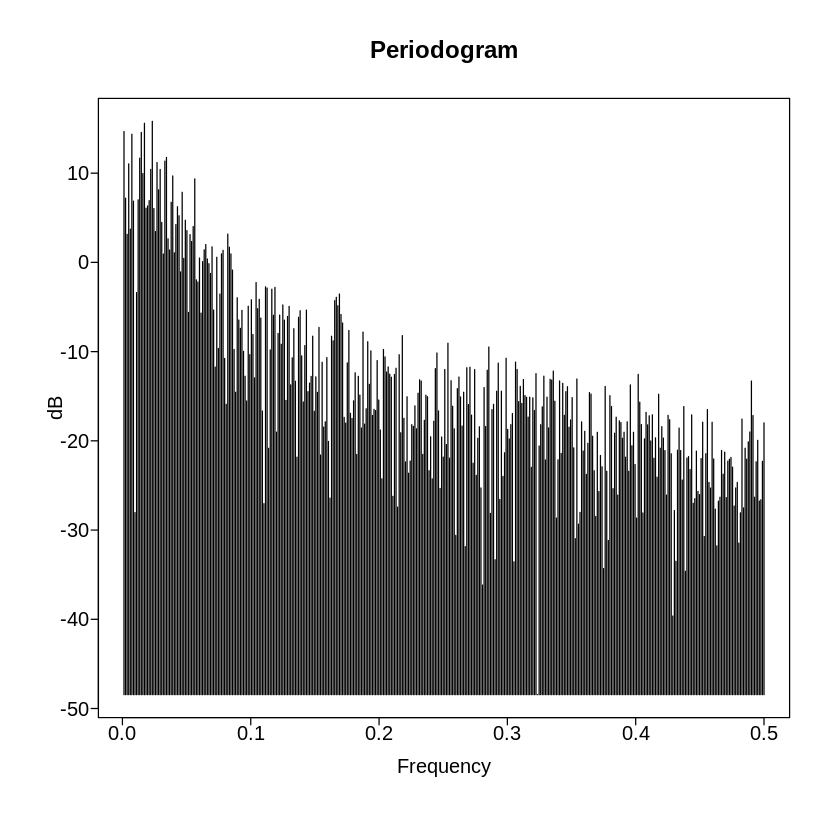

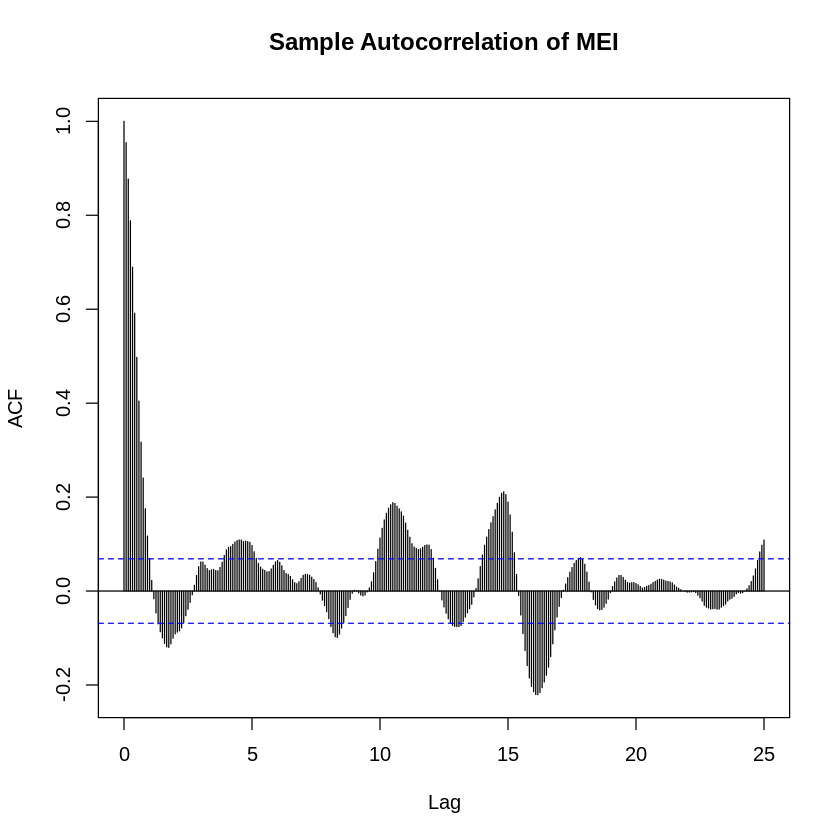

In [94]:
periodogram <- period.wge(mei.ts, plot = TRUE)
acf(mei.ts, type = "correlation", main="Sample Autocorrelation of MEI", lag = 300)

#### MEI Plotts Sample

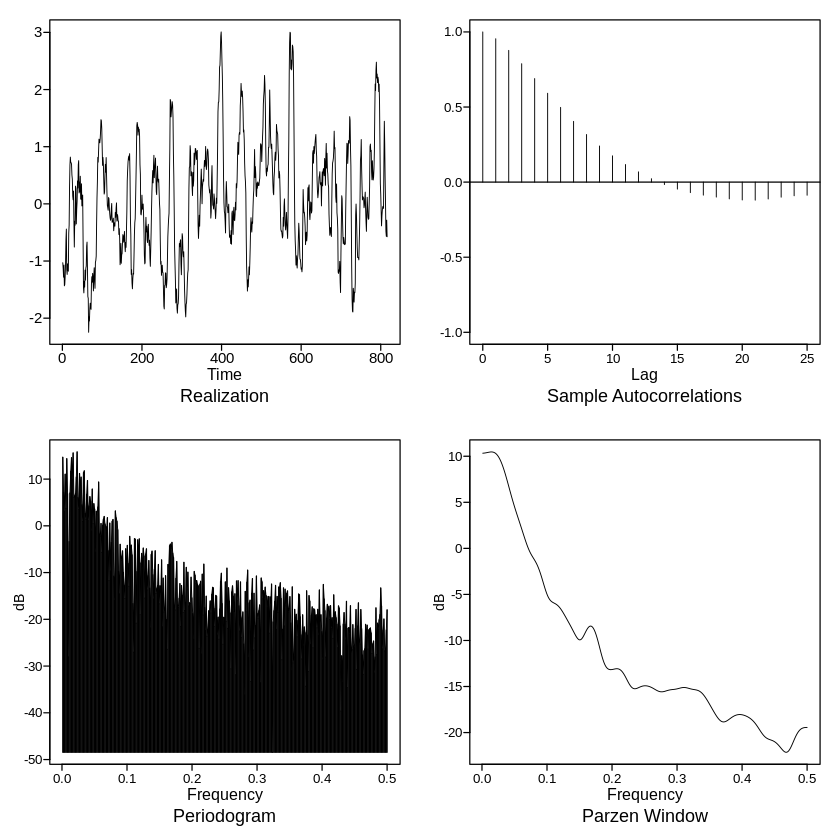

In [85]:
mei_plotts <- plotts.sample.wge(mei.ts)

#### Interpretation
 
From the Parzen window, we see two discernable peaks at about $f = .025$ and $f = .16$. This equates periodic behavior of period $1/.025=40$, or 40 months, and $1/.16 = 6.25$, or 6 and a quarter months. There seems to a  lower-frequency oscillation of just over three years and a higher-frequency oscillation of around 6 months between that represented in the time-series. The autocorrelation function is clear a dampening oscillating pattern with no distinct period.



### Results of Persons Affected by Disasters (PAD)

#### PAD Figure 1
Captures the annual rate of people affected by natural disasters (PAD) (per 1000) from 1964 to 2017.

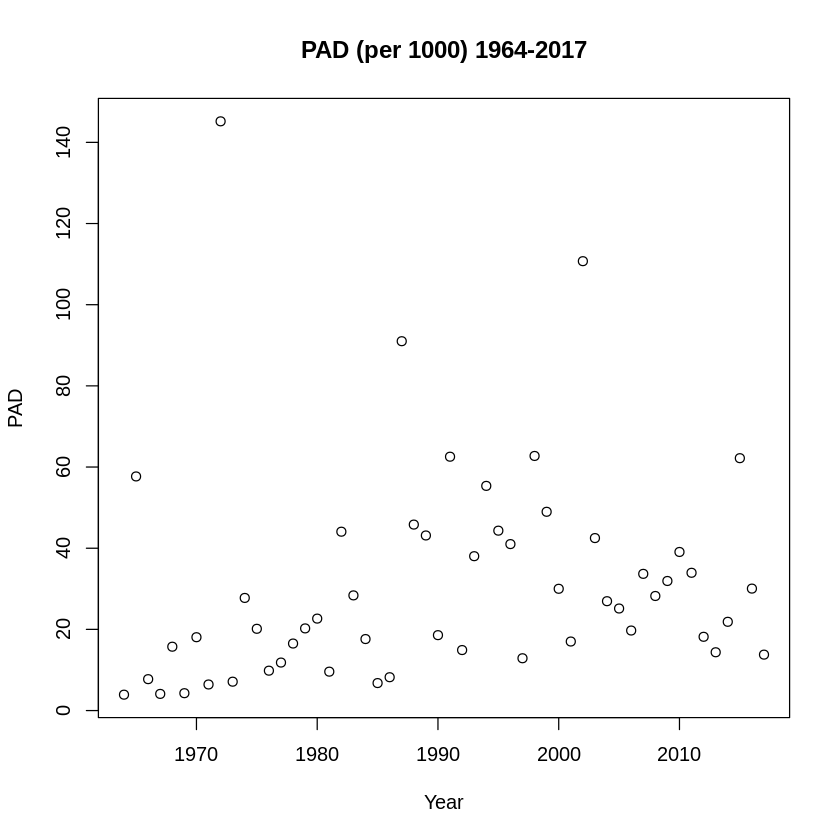

In [30]:
#plotting the PAD time series
plot(new_pad$year, (new_pad$pad_1000),
 main = "PAD (per 1000) 1964-2017",
 xlab = "Year",
 ylab='PAD',
 xlim=c(1964,2017))

#### PAD Time-Series 
Captures the yearly average of PAD values from 1964-2017. 

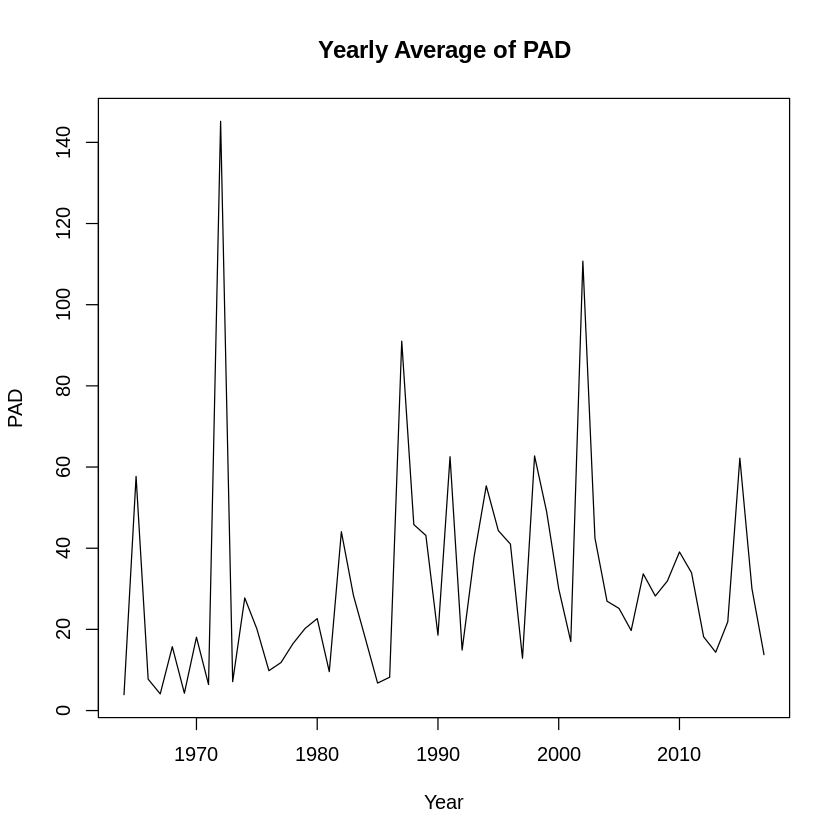

In [63]:
plot(new_pad.ts, xlab = "Year", ylab = "PAD", main = "Yearly Average of PAD")

#### PAD Periodogram & Sample Autocorrelation

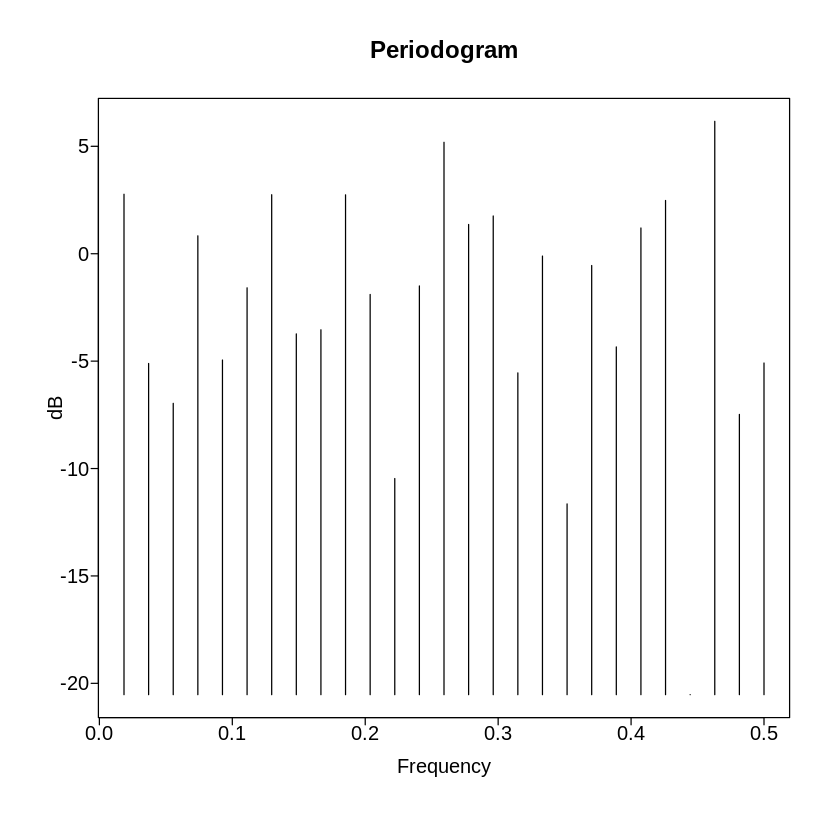

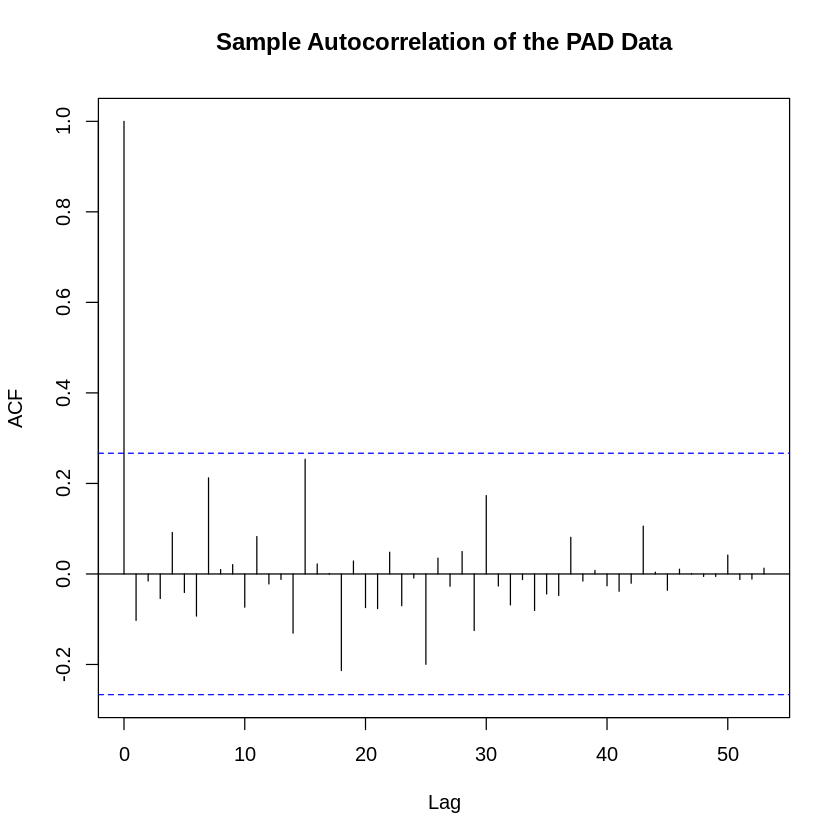

In [97]:
periodogram <- period.wge(new_pad.ts, plot = TRUE)
acf(new_pad.ts, type = "correlation", main="Sample Autocorrelation of the PAD Data", lag = 100)

#### PAD Plotts Sample

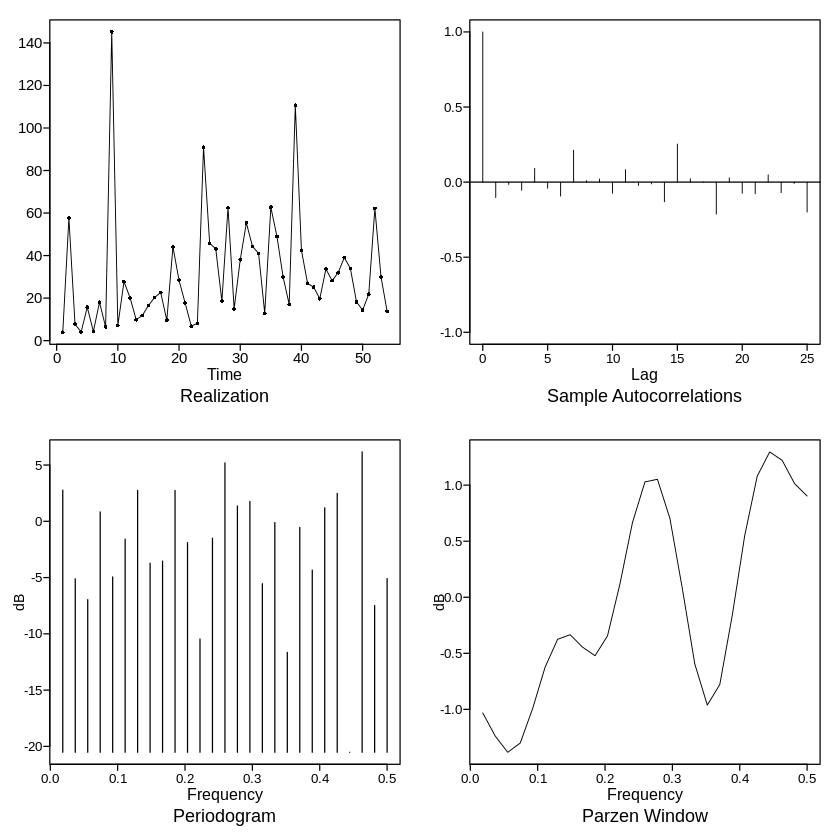

In [95]:
pad_data <- plotts.sample.wge(new_pad.ts)

#### Interpretation 
It is discernible from the time-series that the annual PAD rate (per 1000) is increasing over time. In the sample autocorrelation, there is an immediate drop-off in correlation after lag $0$. With the Parzen window, we see three distinct peaks with the periodogram. There is a peak $f=.14$, $f=.27$ and $f=.45$. This corresponds to periods of $1/.14 =7.14$ years, $1/.27 =3.70$ years and $1/.45=2.22$ years.

### Results of Arctic Oscillation (AO)

#### AO Figure 1.
Captures the annual AO index value from 1964-2017.

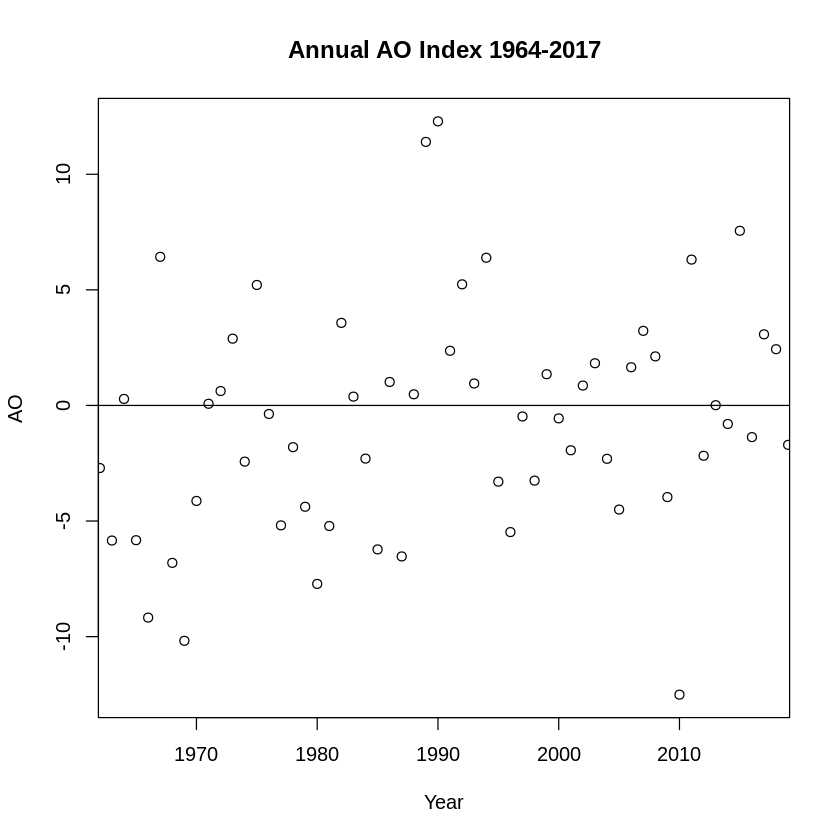

In [52]:
plot(new_aoi$Year, new_aoi$AO.Index, main = "Annual AO Index 1964-2017",
 xlab = "Year",
 ylab='AO',
 xlim=c(1964,2017))
 abline(h=0)

#### AO Time-Series
Captures the monthly running average of the AO index on an annual basis from 1964-2017. 

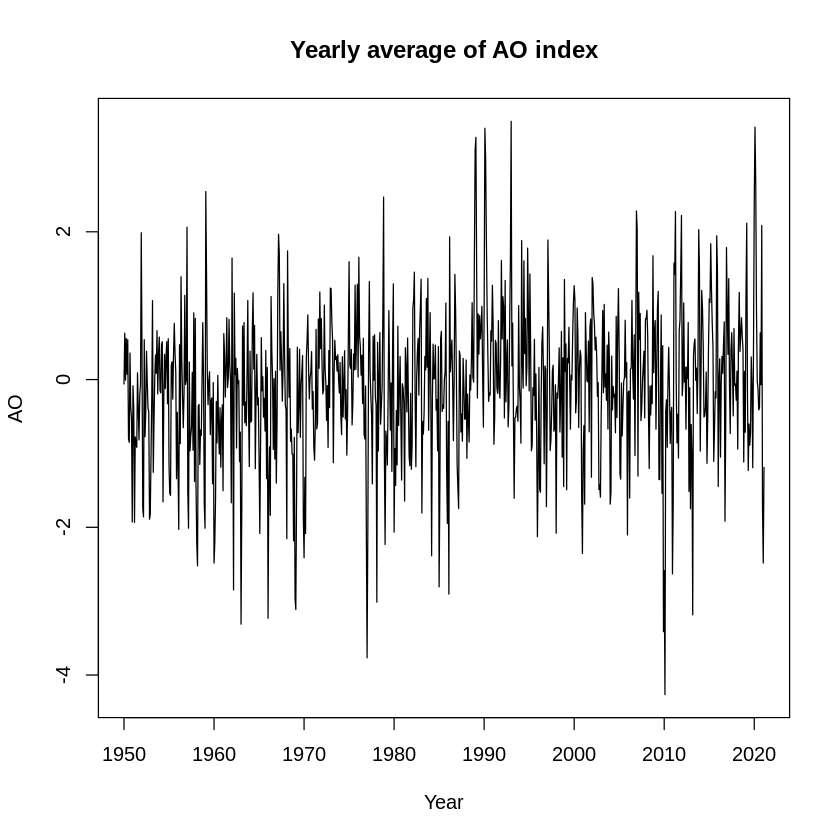

In [57]:
plot(aoi.ts, xlab = "Year", ylab ="AO",main = "Monthly average of AO index")

#### AO Periodogram & Sample Autocorrelation

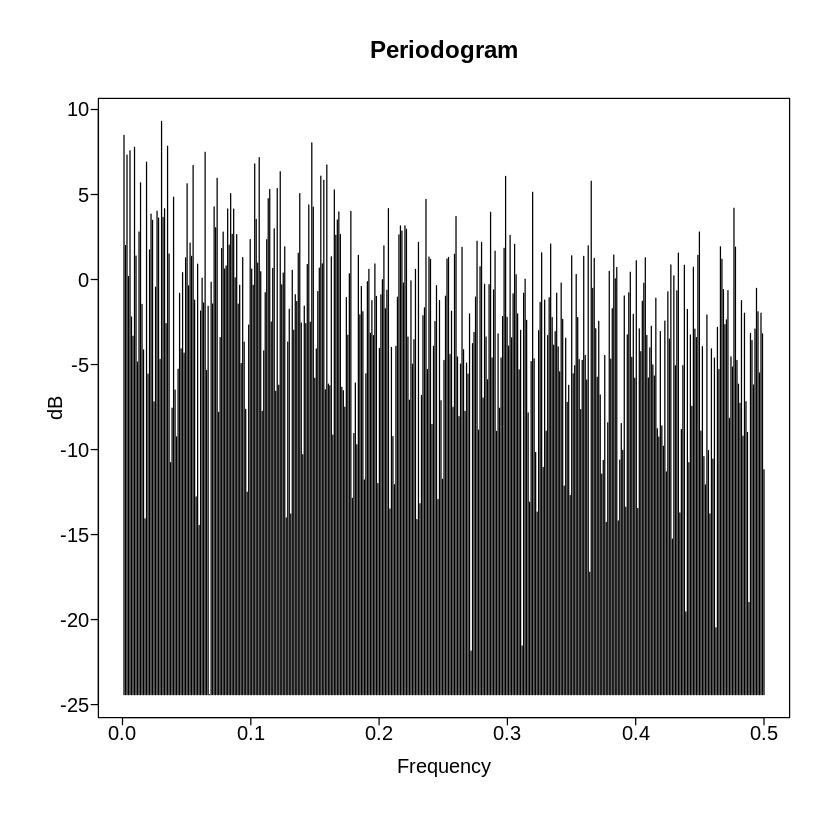

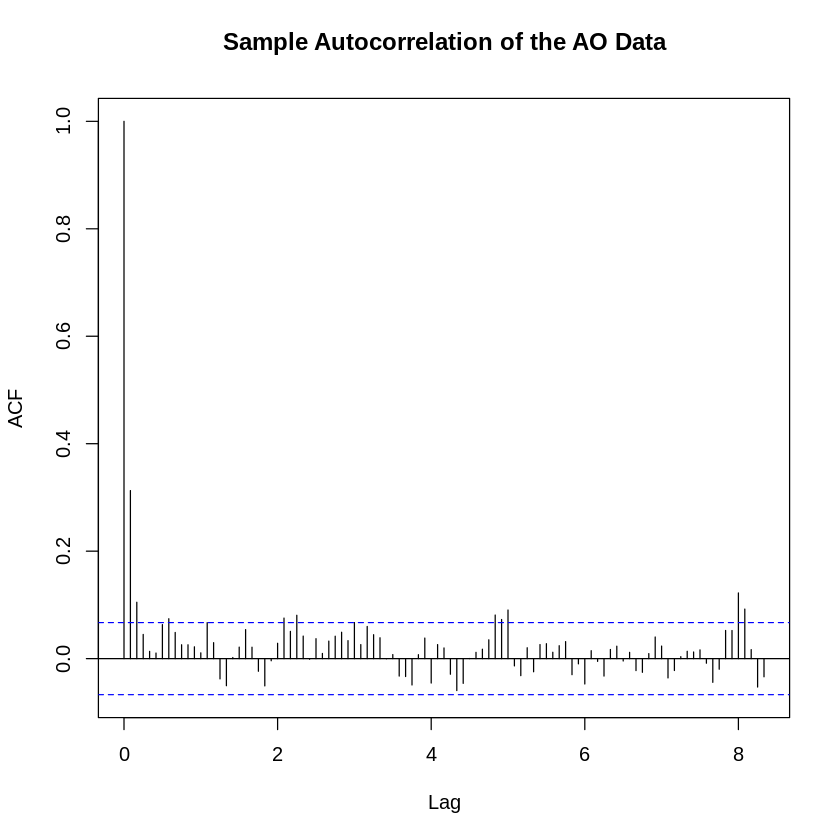

In [81]:
periodogram <- period.wge(aoi.ts, plot = TRUE)
acf(aoi.ts, type = "correlation", main="Sample Autocorrelation of the AO Data", lag = 100)

#### AO Plotts Sample

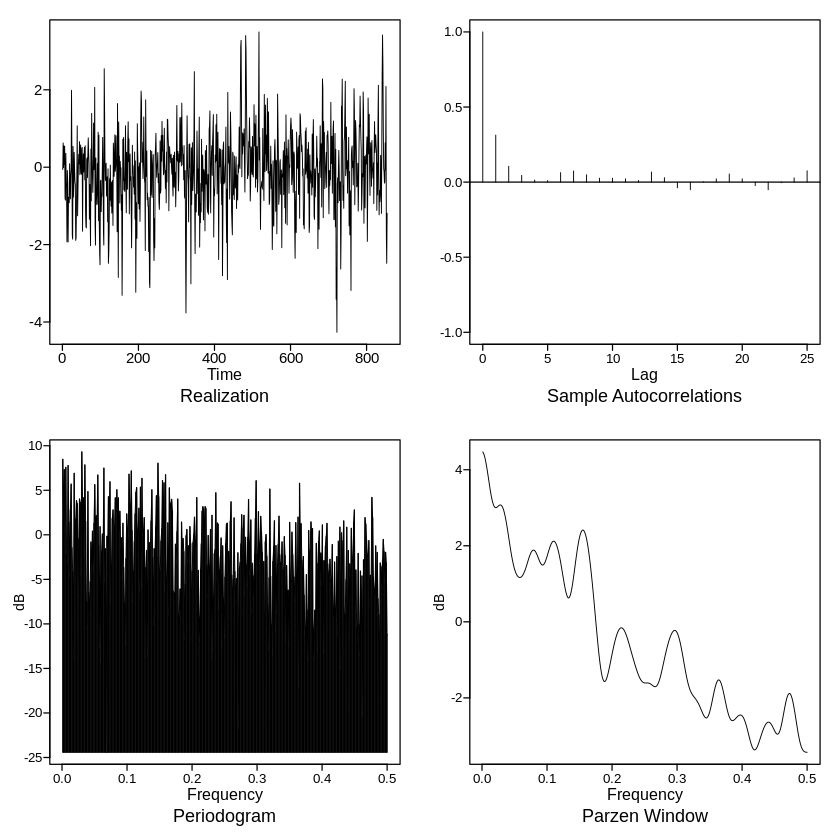

In [98]:
ao_data <- plotts.sample.wge(aoi.ts)

#### Interpretation
Much like the ONI and MEI data, the AO index shows strong oscillations, it seems the magnitudes changes with time. The autocorrelation has an immediate drop off after lag $0$, much like the autocorrelation of PAD. The Parzen window shows that the peak of the periodogram is zero. This indicates a strong irregular, i.e. aperiodic, trend within the data. There does seem to be a harmonic-like tendency within the periodogram, however, it does not follow a strict pattern.


### Identifying El Niño Years

By looking at the ONI time-series we can identify El Niño years by finding five consecutive 3-month rolling average ONI index values greater than 0.5. We see particular strong El Niño phases during the mid-1980s, late 1990s, and early/mid-2010s. Overall, it seems that El Niño years occur every 3 to 6 years. This information is collaborated with data on actual El Niño phases (Null, J.)

## Discussion & Conclusion



Overall, in this lab, I imported and preprocessed four datasets: the Oceanic Niño Index (ONI), the Multi-variate ENSO Index (MEI), and the Persons Affected by Disasters (PAD), calculated on per 1000 people annual basis. I also found a dataset of Arctic Oscillation (AO) which I thought would share similarities with the pattern found with El Niño. With all the datasets, I created a time-series plot, periodogram, sample autocorrelation, and parzen window. Lastly, based upon the results I found I attempted to identify El Niño phrases.
 
The models used in the analysis were for the most part effective. The time-series and parzen window were particularly usual for the analysis. The periodogram and sample autocorrelation offered less valuable information than the other two models.
 
Overall, the findings were much more ambiguous than I had expected. I had anticipated I clear pattern to jump out at me, but this certainly was most the case. While a period of three years seemed to appear throughout the analysis, it was not a clear-cut pattern. Furthermore, the Arctic Oscillation dataset, while similar to El Niño in the type of data it deals with, did not share a similar pattern with El Niño. 
 
I ran into a few challenges along the way, chief among them was locating El Niño phrases. As mentioned above, a clear pattern was not identifiable within the results so pinpointing the El Niño phrases was challenging. The foreignness of the type of data I was working with added to the challenge. 
Another challenge I ran into was calculating the per 1000, the code to do was more involved than I had anticipated. My limited technical knowledge of $R$ made the process difficult, yet ultimately rewarding. 


## References:

Dahlman, L. (2009, August 30). Climate variability: Arctic Oscillation:. Retrieved March 06, 2021, from https://www.climate.gov/news-features/understanding-climate/climate-variability-arctic-oscillation

Null, J. (2021, February). El Niño and La Niña Years and Intensities. Retrieved March 05, 2021, from https://ggweather.com/enso/oni.htm